<a href="https://colab.research.google.com/github/ramyasri2001/Smart-Farming-Drone/blob/main/Cotton_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, platform, sys
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print(platform.platform(), sys.version)

PyTorch: 2.8.0+cu126 | CUDA available: True
Linux-6.6.105+-x86_64-with-glibc2.35 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [ ]:
import zipfile, os
zip_path = '/content/archive (3).zip'
with zipfile.ZipFile(zip_path, 'r') as z: z.extractall("/content/")
print("Contents of /content/ after extraction:", os.listdir("/content/"))
root = "/content/Cotton Disease" # This path will be corrected after inspecting the output
print("Root contains:",os.listdir(root))

Contents of /content/ after extraction: ['.config', '.ipynb_checkpoints', 'Cotton Disease', 'archive (3).zip']
Root contains: ['val', 'train', 'test']


In [ ]:
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.1 MB/s eta 0:00:00


In [ ]:
import os, random, numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from torchmetrics.classification import MulticlassF1Score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [ ]:
IMG_SIZE = 224

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

train_dir = f"{root}/train"
val_dir   = f"{root}/val"
test_dir  = f"{root}/test"

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
val_ds   = datasets.ImageFolder(val_dir,   transform=eval_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=eval_tf)

BATCH = 32
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_ds.classes)
class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']


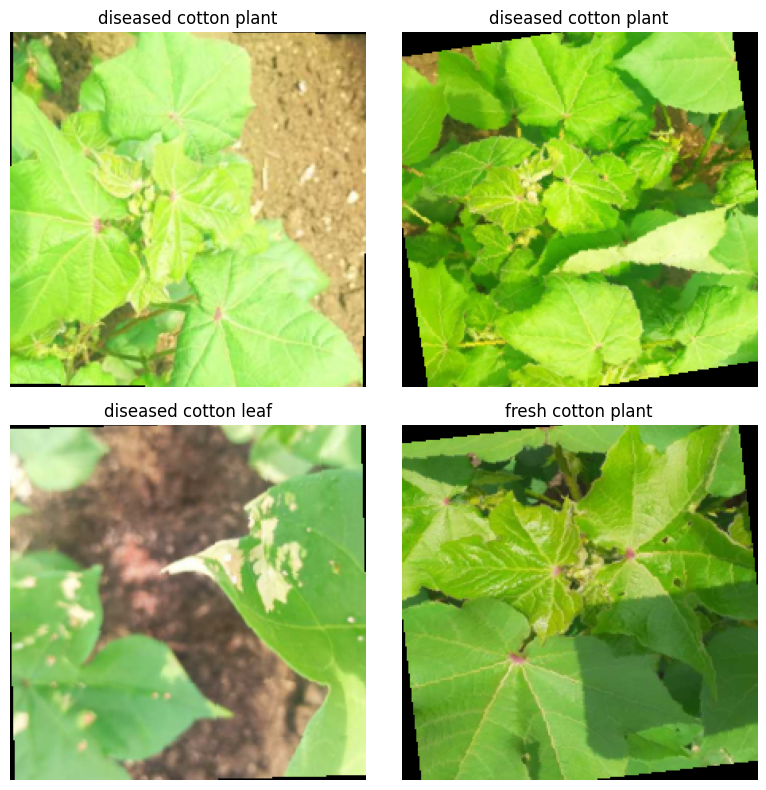

In [ ]:
imgs, labels = next(iter(train_dl))
def denorm(x):
    # reverse ImageNet normalization for display only
    mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
    std  = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
    return (x*std + mean).clamp(0,1)

plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(denorm(imgs[i]).permute(1,2,0).cpu())
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.tight_layout(); plt.show()

In [ ]:
model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
from time import time
EPOCHS = 10
best_f1 = 0.0

f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

def run_epoch(model, loader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss, correct, count = 0.0, 0, 0
    if not train: f1_metric.reset()

    for x,y in loader:
        x,y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        if train: optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item()*x.size(0)
        preds = logits.argmax(1)
        correct += (preds==y).sum().item()
        count += x.size(0)
        if not train: f1_metric.update(preds, y)

    avg_loss = total_loss / count
    acc = correct / count
    if not train:
        f1 = f1_metric.compute().item()
        return avg_loss, acc, f1
    return avg_loss, acc

history = []
start = time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_dl, train=True)
    val_loss, val_acc, val_f1 = run_epoch(model, val_dl, train=False)
    history.append((epoch, tr_loss, tr_acc, val_loss, val_acc, val_f1))
    print(f"Epoch {epoch:02d} | TrainAcc {tr_acc:.3f} | ValAcc {val_acc:.3f} | ValF1 {val_f1:.3f}")
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "/content/best_resnet50.pth")
elapsed = time()-start
print(f"Done. Best Val F1: {best_f1:.3f} | Time: {elapsed/60:.1f} min")

Epoch 01 | TrainAcc 0.556 | ValAcc 0.858 | ValF1 0.835
Epoch 02 | TrainAcc 0.896 | ValAcc 0.980 | ValF1 0.981
Epoch 03 | TrainAcc 0.948 | ValAcc 0.992 | ValF1 0.992
Epoch 04 | TrainAcc 0.949 | ValAcc 0.996 | ValF1 0.995
Epoch 05 | TrainAcc 0.953 | ValAcc 0.988 | ValF1 0.990
Epoch 06 | TrainAcc 0.957 | ValAcc 0.988 | ValF1 0.988
Epoch 07 | TrainAcc 0.967 | ValAcc 0.988 | ValF1 0.988
Epoch 08 | TrainAcc 0.969 | ValAcc 0.984 | ValF1 0.986
Epoch 09 | TrainAcc 0.974 | ValAcc 0.992 | ValF1 0.993
Epoch 10 | TrainAcc 0.978 | ValAcc 1.000 | ValF1 1.000
Done. Best Val F1: 1.000 | Time: 4.2 min


,epoch,tr_loss,tr_acc,val_loss,val_acc,val_f1
0,1,1.010146,0.556125,0.616207,0.857708,0.835237
1,2,0.365218,0.896463,0.092521,0.980237,0.981192
2,3,0.170919,0.947719,0.043334,0.992095,0.991687
3,4,0.152242,0.949257,0.032187,0.996047,0.995179
4,5,0.131022,0.953357,0.043951,0.988142,0.989542
5,6,0.122343,0.957458,0.036105,0.988142,0.988201
6,7,0.099690,0.967196,0.030672,0.988142,0.988201
7,8,0.089073,0.969247,0.037842,0.984190,0.985958
8,9,0.087258,0.974372,0.023884,0.992095,0.993022
9,10,0.066750,0.978473,0.020822,1.000000,1.000000


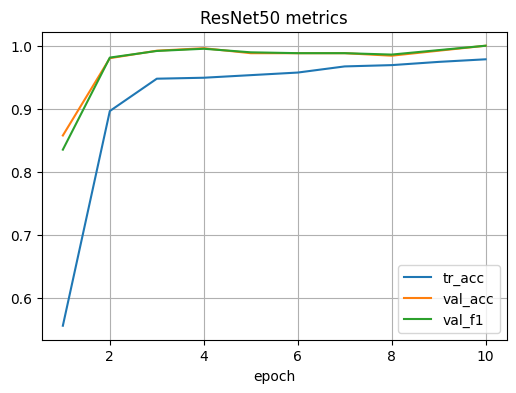

In [ ]:
import pandas as pd
df = pd.DataFrame(history, columns=["epoch","tr_loss","tr_acc","val_loss","val_acc","val_f1"])
display(df)
df.set_index("epoch")[["tr_acc","val_acc","val_f1"]].plot(figsize=(6,4), grid=True, title="ResNet50 metrics");
plt.show()

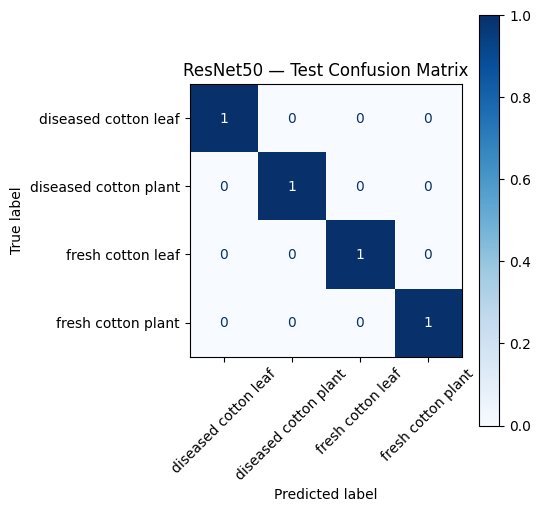

Test Accuracy: 1.0


In [ ]:
@torch.no_grad()
def predict_all(model, loader):
    y_true, y_pred = [], []
    model.eval()
    for x,y in loader:
        x = x.to(device, non_blocking=True)
        p = model(x).argmax(1).cpu().numpy()
        y_pred.extend(p); y_true.extend(y.numpy())
    return np.array(y_true), np.array(y_pred)

# load best checkpoint just in case
model.load_state_dict(torch.load("/content/best_resnet50.pth", map_location=device))
y_true, y_pred = predict_all(model, test_dl)

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(5.5,5.5))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=True)
plt.title("ResNet50 — Test Confusion Matrix")
plt.tight_layout(); plt.show()

test_acc = (y_true == y_pred).mean()
print("Test Accuracy:", round(test_acc, 4))

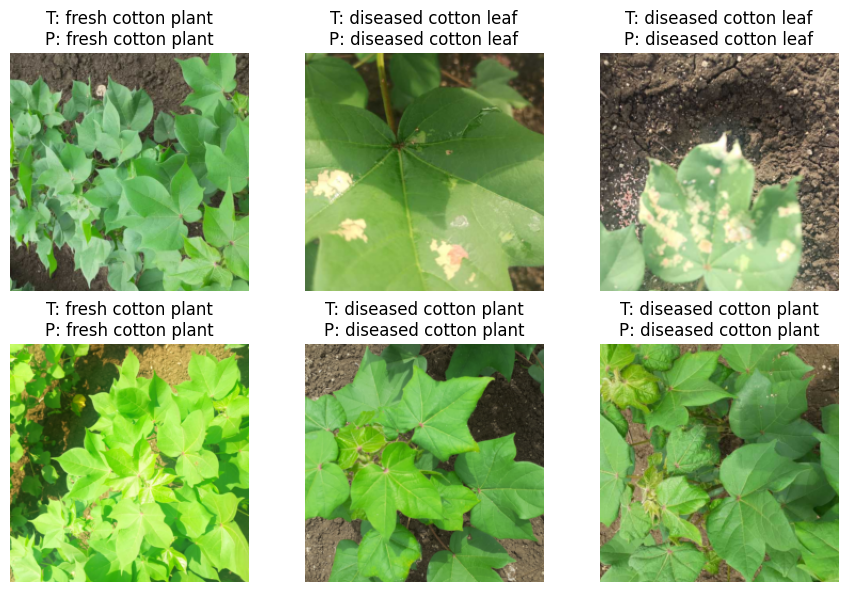

In [ ]:
# show 6 random test samples with true vs pred
import random
idxs = random.sample(range(len(test_ds)), 6)

fig = plt.figure(figsize=(9,6))
cols = 3
for i, idx in enumerate(idxs, 1):
    img, label = test_ds[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    ax = fig.add_subplot(2, cols, i)
    ax.imshow((img.permute(1,2,0)*torch.tensor([0.229,0.224,0.225])+torch.tensor([0.485,0.456,0.406])).clamp(0,1))
    ax.set_title(f"T: {class_names[label]}\nP: {class_names[pred]}")
    ax.axis("off")
plt.tight_layout(); plt.show()